# Homework 4
---

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from janitor import clean_names
from aquarel import load_theme
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

theme = load_theme('umbra_dark')
theme.apply()
rng = np.random.RandomState(50)

## 1).
Read in the data and set things up:

1. Install and load the janitor package. Use its clean_names() function on the Pokémon data.
2. Filter out the rarer Pokémon types: Using the entire data set, create a bar chart of the outcome variable, type_1.
How many classes of the outcome are there? Are there any Pokémon types with very few Pokémon? If so, which ones?

For this assignment, we’ll handle the rarer classes by grouping them, or “lumping them,” together into an ‘other’ category. Using the forcats package, determine how to do this, and lump all the other levels together except for the top 6 most frequent (which are Bug, Fire, Grass, Normal, Water, and Psychic).

3. Convert type_1, legendary, and generation to factors.

4. Do an initial split of the data; you can choose the percentage for splitting. Stratify on the outcome variable.

5. Fold the training set using v-fold cross-validation, with v = 5. Stratify on the outcome variable.

6. Set up a recipe to predict type_1 with legendary, generation, sp_atk, attack, speed, defense, hp, and sp_def:

* Dummy-code legendary and generation;
* Center and scale all predictors.

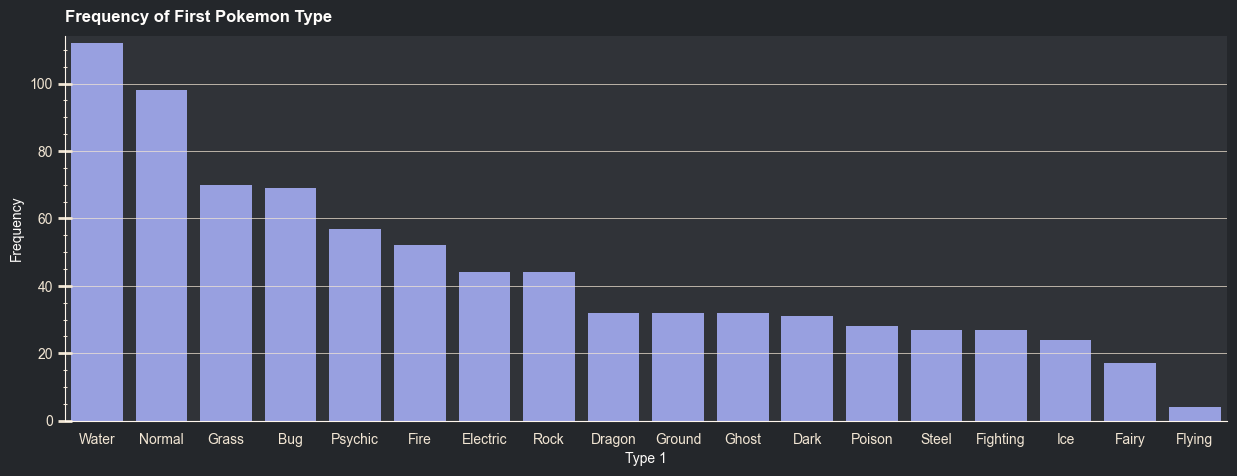

type_1
Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: count, dtype: int64


In [300]:
# Load Pokemon data
pokemon = pd.read_csv('Pokemon.csv')

# Clean column names
pokemon = pokemon.clean_names()

# Create bar chart of the outcome variable `type_1`
plt.figure(figsize=(15,5))
sns.countplot(data=pokemon, x='type_1', order=pokemon['type_1'].value_counts().index)
plt.xlabel('Type 1')
plt.ylabel('Frequency')
plt.tick_params(bottom=False, which='both')
plt.title('Frequency of First Pokemon Type')
plt.show()

# Print frequencies
print(pokemon['type_1'].value_counts())

We have 18 different types for the `type_1` column. Depending on your definition of very few, we can say Steel, Fighting, Ice, Fairy, and Flying all have very few Pokemon (<30).

In [301]:
# Replace all types not included in our most frequent types
frequent_types = ['Bug', 'Fire', 'Grass', 'Normal', 'Water', 'Psychic']
pokemon['type_1'] = pokemon['type_1'].apply(lambda x: x if x in frequent_types else 'Other')

# Convert type_1, legendary, and generation to categorical data
pokemon['type_1'] = pokemon['type_1'].astype('category')
pokemon['legendary'] = pokemon['legendary'].astype('category')
pokemon['generation'] = pokemon['generation'].astype('category')

# Split the data while stratifying on the outcome variable
train_data, test_data = train_test_split(pokemon, train_size=0.7, test_size=0.3, stratify=pokemon['type_1'], random_state=rng)

# Perform k-fold cross-validation with 5 folds
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

# Set up preprocessing pipeline
numeric_features = ['sp_atk', 'attack', 'speed', 'defense', 'hp', 'sp_def']
categorical_features = ['legendary', 'generation']
preprocessor = ColumnTransformer(transformers=[('numerical', StandardScaler(), numeric_features),
                                               ('categorical', OneHotEncoder(drop='first'), categorical_features)],
                                verbose_feature_names_out=False)

## 2).
Create a correlation matrix of the training set, using the corrplot package. Note: You can choose how to handle the continuous variables for this plot; justify your decision(s).

What relationships, if any, do you notice? Do these relationships make sense to you?

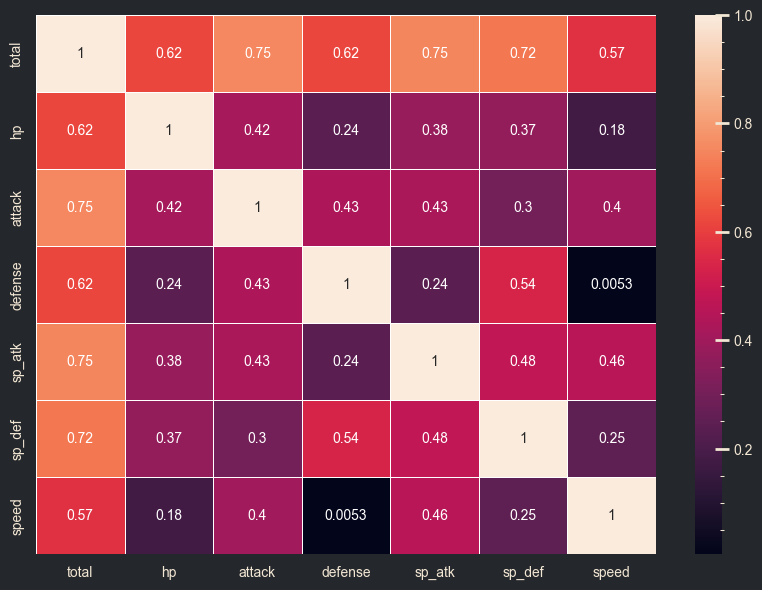

In [302]:
# Print correlation matrix
plt.figure(figsize=(10,7))
sns.heatmap(train_data.drop('#', axis=1).corr(numeric_only=True), annot=True, linewidths=0.5)
plt.tick_params(left=False, bottom=False, which='both')
plt.grid(visible=False, which='both')
plt.show()

I decided to drop the ID's of the pokemon since in theory this is a random number and shouldn't have any effect on the stats of a pokemon. I notice that all our continuous variables are positively correlated with `total`, which makes sense because this variable is simply a sum of all the numerical stats.

## 3).
First, set up a decision tree model and workflow. Tune the cost_complexity hyperparameter. Use the same levels we used in the Lab – that is, range = c(-3, -1). Specify that the metric we want to optimize is roc_auc.

Print an autoplot() of the results. What do you observe? Does a single decision tree perform better with a smaller or larger complexity penalty?

In [303]:
# Spit training and testing data into our predictors and outcome variables
X_train_data = train_data[numeric_features + categorical_features]
Y_train_data = train_data['type_1']
X_test_data = test_data[numeric_features + categorical_features]
Y_test_data = test_data['type_1']

# Create our pipeline with our preprocessing and the model
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', DecisionTreeClassifier(random_state=rng))])

# Set up our paramter grid for cross validation
dt_param_grid = {'model__ccp_alpha' : np.logspace(-3, -1, num=10)}

# Perform the grid search to tune the ccp_alpha hyperparameter
dt_grid_search = GridSearchCV(estimator=dt_pipeline, param_grid=dt_param_grid, cv=strat_k_fold, scoring='roc_auc_ovr', n_jobs=-1)

# Fit the grid search
dt_grid_search.fit(X_train_data, Y_train_data)

GridSearchCV(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x21CF343F740, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['sp_atk',
                                                                          'attack',
                                                                          'speed',
                                                                          'defense',
                                                                          'hp',
                                                                          'sp_def']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['legendary',
                                                                          'generation'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x21CF343F740))]),
             n_jobs=-1,
             param_grid={'model__ccp_alpha': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])},
             scoring='roc_auc_ovr')

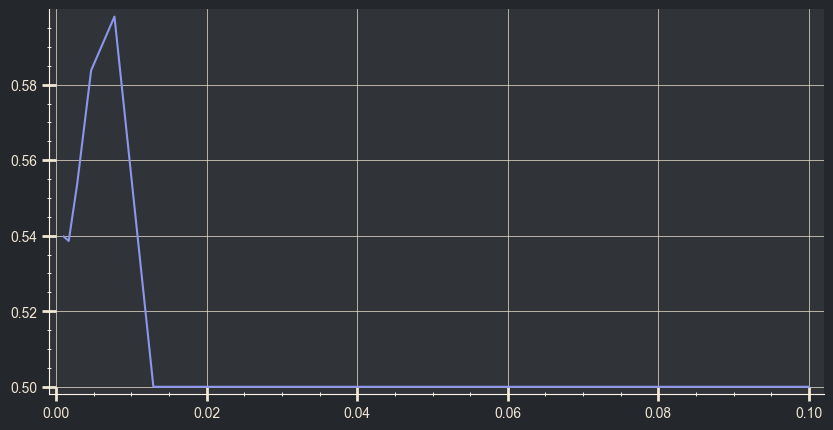

In [304]:
# Put the results into a dataframe
results = pd.DataFrame(dt_grid_search.cv_results_)

# Print a plot of our ROC AUC vs. the cost complexity parameter
plt.figure(figsize=(10,5))
plt.plot(results['param_model__ccp_alpha'], results['mean_test_score'])
plt.show()

It seems that a single decision tree performs better with a smaller complexity penalty. This is likely due to the fact that when that hyperparameter is small, the decision tree can grow larger and capture more details.

## 4).
What is the roc_auc of your best-performing pruned decision tree on the folds? Hint: Use collect_metrics() and arrange().

In [305]:
# Print best-performing decision tree
print(f'Best ROC AUC Score for Decision Tree: {dt_grid_search.best_score_:.4f}')

Best ROC AUC Score for Decision Tree: 0.5980


## 5).
Using rpart.plot, fit and visualize your best-performing pruned decision tree with the training set.

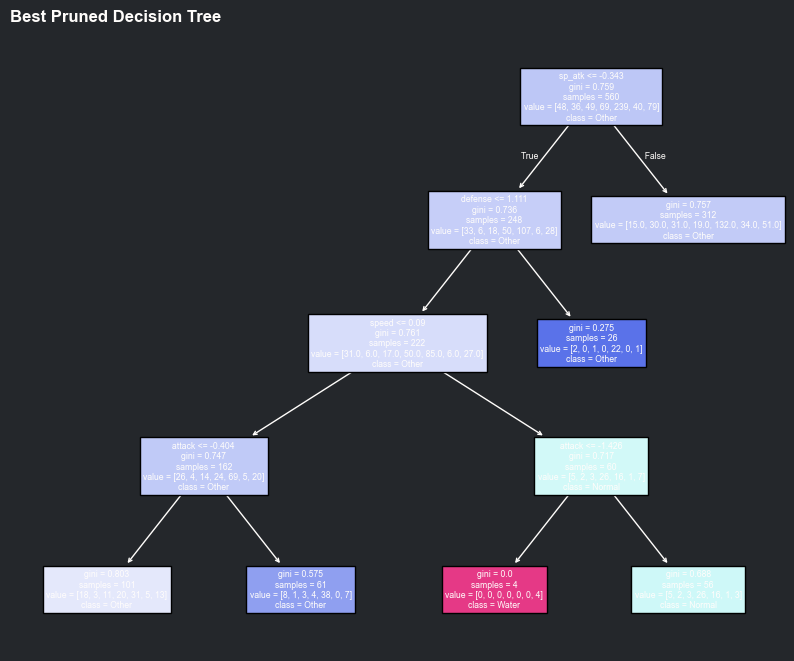

In [306]:
# Get our best performing decision tree
best_tree = dt_grid_search.best_estimator_

# Plot our best performing tree
plt.figure(figsize=(10,8))
tree.plot_tree(best_tree.named_steps['model'], filled=True, feature_names=best_tree.named_steps['preprocessor'].get_feature_names_out(), class_names=best_tree.classes_)
plt.title('Best Pruned Decision Tree')
plt.show()

## 6).
Now set up a random forest model and workflow. Use the ranger engine and set importance = "impurity". Tune mtry, trees, and min_n. Using the documentation for rand_forest(), explain in your own words what each of these hyperparameters represent.

Create a regular grid with 8 levels each. You can choose plausible ranges for each hyperparameter. Note that mtry should not be smaller than 1 or larger than 8. Explain why not. What type of model would mtry = 8 represent?

In [307]:
# Create our random forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestClassifier(random_state=rng))])

# Set up our paramter grid for cross validation
rf_param_grid = {'model__n_estimators' : np.linspace(50, 1000, 8, dtype='int'),
                 'model__max_features' : np.linspace(1, 8, 8, dtype='int'),
                 'model__min_samples_leaf' : np.linspace(1, 8, 8, dtype='int')}

# Perform the grid search to tune the ccp_alpha hyperparameter
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=strat_k_fold, scoring='roc_auc_ovr', n_jobs=-1)

# Fit the model
rf_grid_search.fit(X_train_data, Y_train_data)

GridSearchCV(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x21CF343F740, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['sp_atk',
                                                                          'attack',
                                                                          'speed',
                                                                          'defense',
                                                                          'hp',
                                                                          'sp_def']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['legendary',
                                                                          'generation'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        RandomForestClassifier(random_state=RandomState(MT19937) at 0x21CF343F740))]),
             n_jobs=-1,
             param_grid={'model__max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'model__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'model__n_estimators': array([  50,  185,  321,  457,  592,  728,  864, 1000])},
             scoring='roc_auc_ovr')

## 7).
Specify roc_auc as a metric. Tune the model and print an autoplot() of the results. What do you observe? What values of the hyperparameters seem to yield the best performance?

<Figure size 1000x500 with 0 Axes>

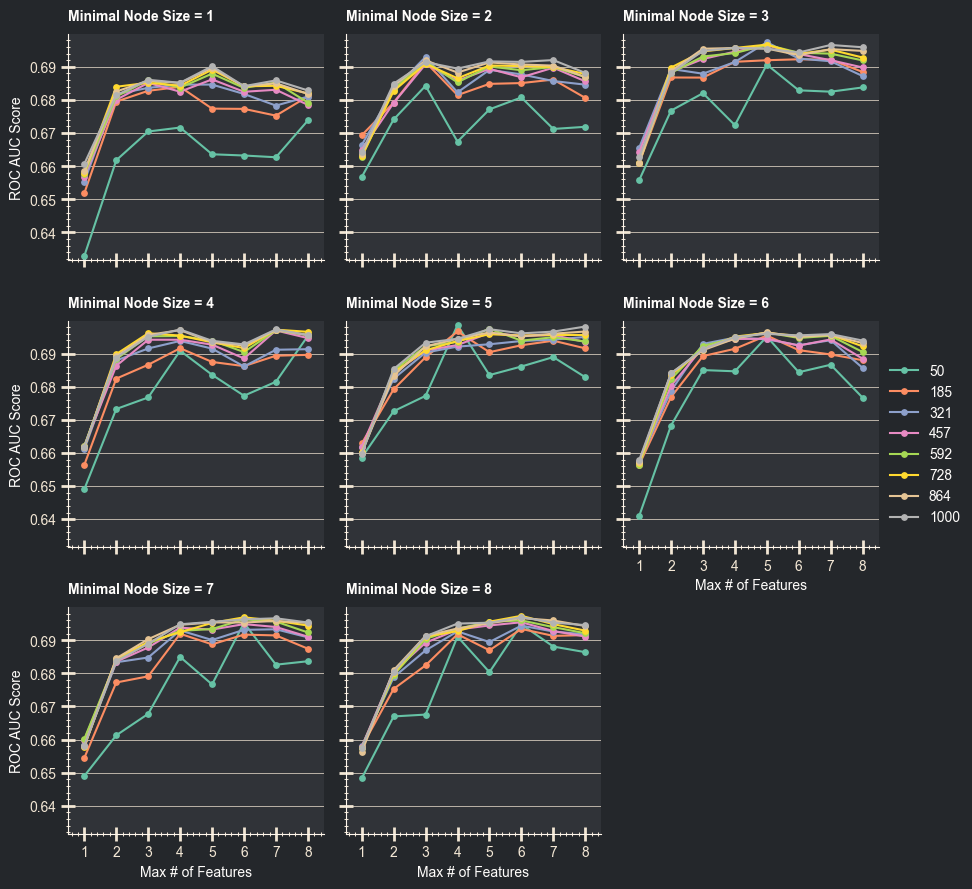

In [334]:
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

plt.figure(figsize=(10,5))
g = sns.FacetGrid(data=rf_results, col='param_model__min_samples_leaf', col_wrap=3)
g.map_dataframe(sns.pointplot, x='param_model__max_features', y='mean_test_score', hue='param_model__n_estimators', linewidth=1.5, palette='Set2')
g.add_legend()
g.set_axis_labels('Max # of Features', 'ROC AUC Score')
g.set_titles('Minimal Node Size = {col_name}')
plt.show()

## 8).


In [335]:
# Print best-performing random forest
print(f'Best ROC AUC Score for Random Forest: {rf_grid_search.best_score_:.4f}')

Best ROC AUC Score for Random Forest: 0.6986
